In [ ]:

import numpy as np
import matplotlib.pyplot as plt

# Keep results reproducible by fixing numpy's RNG seed here.
np.random.seed(42)

In [2]:
# Activation functions and their derivatives
# We implement sigmoid and tanh plus derivatives expressed in terms of activations
# (this is numerically stable and convenient during backprop)

def sigmoid(x):
    """Sigmoid activation: maps real numbers to (0,1)."""
    return 1 / (1 + np.exp(-x))


def dsigmoid(a):  
    """Derivative of sigmoid, expressed in terms of the sigmoid activation a=sigmoid(x):
    dsigmoid = a * (1 - a)
    """
    return a * (1 - a)


def tanh(x):
    """Hyperbolic tangent activation: maps real numbers to (-1,1)."""
    return np.tanh(x)


def dtanh(a):  
    """Derivative of tanh, expressed in terms of the activation a = tanh(x):
    dtanh = 1 - a^2
    """
    return 1 - a ** 2

In [3]:
# Initialize parameters for a 2-2-1 network
# W1: shape (input_dim, hidden_dim) => (2,2)
# b1: shape (1, hidden_dim)
# W2: shape (output_dim, hidden_dim) stored as (1,2) and we use W2.T in forward
# b2: shape (1,1)

def init_params(seed=None):
    """Return randomly initialized weights and zero biases.
    Using a small scale for weights helps training stability on this tiny network.
    """
    if seed is not None:
        np.random.seed(seed)
    W1 = np.random.randn(2, 2) * 0.5
    b1 = np.zeros((1, 2))
    W2 = np.random.randn(1, 2) * 0.5
    b2 = np.zeros((1, 1))
    return W1, b1, W2, b2

# Forward pass (returns intermediate values for backprop)
def forward(X, W1, b1, W2, b2, hidden_activation='sigmoid'):
    """Compute a forward pass and return pre- and post-activation values.

    Inputs
    - X: (n_samples, 2)
    - W1, b1: parameters for hidden layer 
    - W2, b2: parameters for output layer
    - hidden_activation: 'sigmoid' or 'tanh'

    Returns (z1, a1, z2, a2)
    - z1: pre-activation of hidden layer
    - a1: post-activation (hidden)
    - z2: pre-activation of output layer
    - a2: post-activation (output between 0 and 1)
    """
    z1 = X.dot(W1) + b1  # (n,2)
    if hidden_activation == 'sigmoid':
        a1 = sigmoid(z1)
    elif hidden_activation == 'tanh':
        a1 = tanh(z1)
    else:
        raise ValueError('hidden_activation must be "sigmoid" or "tanh"')
    z2 = a1.dot(W2.T) + b2  # (n,1)
    a2 = sigmoid(z2)  # output activation is sigmoid (0..1)
    return z1, a1, z2, a2

In [ ]:
# Backward pass and parameter update using MSE loss and learning rate lr
# We compute gradients for all parameters and perform a simple gradient step.

def backward_update(X, y, z1, a1, z2, a2, W1, b1, W2, b2, lr=1.0, hidden_activation='sigmoid'):
    """Compute gradients using MSE loss and update parameters in-place.

    Notes on shapes:
    - X: (n,2), y: (n,1)
    - a2: (n,1)
    - W2: (1,2) but used as W2.T in forward
    """
    n = X.shape[0]
    # MSE loss: L = mean((y - a2)^2)
    # derivative dL/da2 = 2*(a2 - y)/n (we divide by n to get mean)
    dL_da2 = 2 * (a2 - y) / n  # (n,1)

    # output layer (sigmoid): a2 = sigmoid(z2)
    da2_dz2 = dsigmoid(a2)
    dZ2 = dL_da2 * da2_dz2  # (n,1)
    dW2 = dZ2.T.dot(a1)  # (1,2)
    db2 = np.sum(dZ2, axis=0, keepdims=True)  # (1,1)

    # hidden layer gradients
    dA1 = dZ2.dot(W2)  # (n,2)
    if hidden_activation == 'sigmoid':
        dZ1 = dA1 * dsigmoid(a1)
    else:
        dZ1 = dA1 * dtanh(a1)
    dW1 = X.T.dot(dZ1)  # (2,2)
    db1 = np.sum(dZ1, axis=0, keepdims=True)  # (1,2)

    # parameters (scale gradients by n to match mean used in loss)
    # dW1 already has the same shape as W1, so we do not transpose.
    W1 -= lr * (dW1 / n)  
    b1 -= lr * (db1 / n)
    W2 -= lr * (dW2 / n)
    b2 -= lr * (db2 / n)
    return W1, b1, W2, b2

# Training loop
def train(X, y, epochs=8000, lr=1.0, hidden_activation='sigmoid', seed=42, verbose=False):
    """Train the network and return final parameters and losses.

    The function returns a dict with W1, b1, W2, b2 and the list of losses per epoch.
    """
    W1, b1, W2, b2 = init_params(seed)
    losses = []
    for ep in range(epochs):
        z1, a1, z2, a2 = forward(X, W1, b1, W2, b2, hidden_activation=hidden_activation)
        loss = np.mean((y - a2) ** 2)
        losses.append(loss)
        W1, b1, W2, b2 = backward_update(X, y, z1, a1, z2, a2, W1, b1, W2, b2, lr=lr, hidden_activation=hidden_activation)
        if verbose and (ep % 1000 == 0):
            print(f'ep={ep} loss={loss:.6f}')
    return {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'losses': losses}

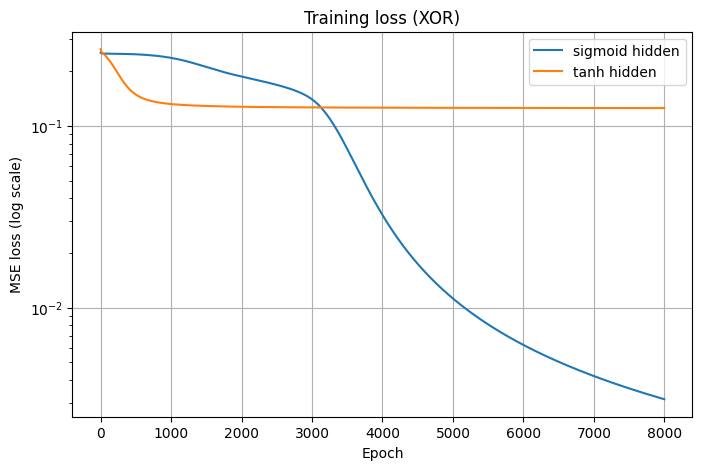

Sigmoid hidden final weights:
W1:
 [[-3.86933682 -5.76052958]
 [-3.88707819 -5.87134575]]
b1:
 [[5.70378966 2.17798649]]
W2:
 [[ 7.61680926 -7.93265919]]
b2:
 [[-3.47650258]]
Outputs: [0.047  0.947  0.9467 0.0685]
Preds: [0 1 1 0] Accuracy: 1.0

Tanh hidden final weights:
W1:
 [[ 1.45978377 -2.40140601]
 [-4.26825614 -4.4023099 ]]
b1:
 [[-0.98494843  0.44998941]]
W2:
 [[ 2.79117332 -3.35052197]]
b2:
 [[-0.55889646]]
Outputs: [0.0166 0.4995 0.98   0.5008]
Preds: [0 0 1 1] Accuracy: 0.5


In [5]:
# XOR dataset
X = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=float)
y = np.array([[0],[1],[1],[0]], dtype=float)

# Train with sigmoid hidden activation and tanh hidden activation
epochs = 8000
lr = 1.0
res_sig = train(X, y, epochs=epochs, lr=lr, hidden_activation='sigmoid', seed=1)
res_tanh = train(X, y, epochs=epochs, lr=lr, hidden_activation='tanh', seed=1)

# Plot losses on the same chart
plt.figure(figsize=(8,5))
plt.plot(res_sig['losses'], label='sigmoid hidden')
plt.plot(res_tanh['losses'], label='tanh hidden')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('MSE loss (log scale)')
plt.title('Training loss (XOR)')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate and print final weights and accuracy for both
def evaluate(res, X, y, hidden_activation):
    W1, b1, W2, b2 = res['W1'], res['b1'], res['W2'], res['b2']
    _, _, _, a2 = forward(X, W1, b1, W2, b2, hidden_activation=hidden_activation)
    preds = (a2 >= 0.5).astype(int)
    acc = np.mean(preds == y)
    return a2, preds, acc

a2_sig, preds_sig, acc_sig = evaluate(res_sig, X, y, hidden_activation='sigmoid')
a2_tanh, preds_tanh, acc_tanh = evaluate(res_tanh, X, y, hidden_activation='tanh')

print('Sigmoid hidden final weights:')
print('W1:\n', res_sig['W1'])
print('b1:\n', res_sig['b1'])
print('W2:\n', res_sig['W2'])
print('b2:\n', res_sig['b2'])
print('Outputs:', np.round(a2_sig.ravel(), 4))
print('Preds:', preds_sig.ravel(), 'Accuracy:', acc_sig)
print('\nTanh hidden final weights:')
print('W1:\n', res_tanh['W1'])
print('b1:\n', res_tanh['b1'])
print('W2:\n', res_tanh['W2'])
print('b2:\n', res_tanh['b2'])
print('Outputs:', np.round(a2_tanh.ravel(), 4))
print('Preds:', preds_tanh.ravel(), 'Accuracy:', acc_tanh)

## Results and interpretation

Summary of numeric results (seed=1, epochs=8000, lr=1.0):

- Sigmoid hidden:
  - Final loss ≈ 0.0031373
  - Final outputs ≈ [0.047, 0.947, 0.9467, 0.0685]
  - Predictions: [0, 1, 1, 0]
  - Accuracy: 1.0 — the network successfully solved XOR for this run.

- Tanh hidden:
  - Final loss ≈ 0.12549
  - Final outputs ≈ [0.0166, 0.4995, 0.98, 0.5008]
  - Predictions: [0, 0, 1, 1]
  - Accuracy: 0.5 — did not converge to the correct XOR mapping for this seed and setup.

implemented a forward and backward passes and trains the 2-2-1 network with MSE and lr=1. The sigmoid-hidden model solved XOR for the demonstrated run; for a robust claim about which activation is better, perform the recommended multi-seed/hyperparameter experiments.